# Overview of the WildlifeReID-10k dataset

This notebook show a basic analysis of the [WildlifeReID-10k](https://www.kaggle.com/datasets/wildlifedatasets/wildlifereid-10k) dataset. We first analyze the dataset and then show to evaluate an already trained model. We first import the required packages.

In [3]:
pip install git+https://github.com/WildlifeDatasets/wildlife-datasets@develop git+https://github.com/WildlifeDatasets/wildlife-tools


  Cloning https://github.com/WildlifeDatasets/wildlife-datasets (to revision develop) to c:\users\morten\appdata\local\temp\pip-req-build-k7kgujoc
  Resolved https://github.com/WildlifeDatasets/wildlife-datasets to commit 959c6c01a8317ed4f162ebfdf4b5e63faad60228
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/WildlifeDatasets/wildlife-tools to c:\users\morten\appdata\local\temp\pip-req-build-5x90_j1f
  Resolved https://github.com/WildlifeDatasets/wildlife-tools to commit 71aa4656d16afe4caae6d84af642bab81dc2d06d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements

  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-datasets 'C:\Users\Morten\AppData\Local\Temp\pip-req-build-k7kgujoc'
  Running command git checkout -b develop --track origin/develop
  branch 'develop' set up to track 'origin/develop'.
  Switched to a new branch 'develop'
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-tools 'C:\Users\Morten\AppData\Local\Temp\pip-req-build-5x90_j1f'
  Running command git clone --filter=blob:none --quiet https://github.com/cvg/LightGlue.git 'C:\Users\Morten\AppData\Local\Temp\pip-install-kwvl5xb2\lightglue_6164a0c2e18f4ffc86f48a4749be0e2c'


In [6]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from wildlife_datasets.datasets import WildlifeReID10k
from wildlife_datasets.splits import analyze_split
from wildlife_datasets.metrics import BAKS, BAUS
#from utils_wildlifereid10k.utils_wildlifereid10k import get_summary_species, compute_predictions, mean

Now we load the dataset and show the dataframe with 140,488 images, where each depicts an individual animal. There are 10,772 individual animals.

In [7]:
root_data = '/kaggle/input/wildlifereid-10k'
dataset = WildlifeReID10k(root_data, check_files=False)
metadata = dataset.metadata
metadata

Exception: root does not exist. You may have have mispelled it.

We plot a 3*4 sample of the dataset. It is clear that the depicted species, the image quality and the time conditions are extremely different for all images. The sample contains three underwater photos and one night photo.

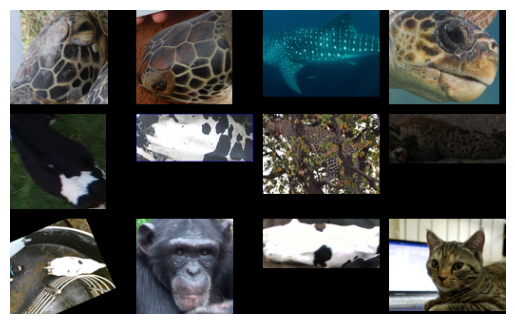

In [4]:
dataset.plot_grid(n_rows=3, n_cols=4, idx=np.arange(0, len(dataset), 10000)[::-1]);

We show summary of the incorporated species. The majority of species are wild and domestic species are in minority.

In [5]:
get_summary_species(metadata)

,images,individuals
bird,2629,50
cat,13021,509
chicken,1146,50
chimpanzee,6974,106
cow,23465,465
dog,10020,1584
dolphin,2657,82
fish,336,6
giraffe,2002,328
hyena,3129,256


## Splits for algorithm training

WildlifeReID-10k contains a default split. The split is open-set, meaning that some animals are only in the testing set but not in the training set. For such animals, the algorithm should predict that they are new. The evaluation is possible for both the open-set and closed-set, where for the latter the individuals only in the testing set are ignored. The following summary shows that the training set consists of 79.65% images, the new individuals 10.68% and the known individuals the remaining 9.67%. In other words, the open-set problem will be evaluated at 20.35% of the dataset, while the closed-set only at 9.67% of the dataset.

In [6]:
idx_train = np.where(metadata['split'] == 'train')[0]
idx_test = np.where(metadata['split'] == 'test')[0]
analyze_split(metadata, idx_train, idx_test)

Split: time-unaware open-set
Samples: train/test/unassigned/total = 111897/28591/0/140488
Classes: train/test/unassigned/total = 9826/7632/0/10772
Samples: train only/test only        = 19291/15011
Classes: train only/test only/joint  = 3140/946/6686

Fraction of train set     = 79.65%
Fraction of test set only = 10.68%


We can indeed verify that there are 946 individuals which are in the testing set only.

In [7]:
identity = metadata['identity'].to_numpy()
identity_train = identity[metadata['split'] == 'train']
identity_test = identity[metadata['split'] == 'test']
identity_test_only = list(set(identity_test) - set(identity_train))
len(identity_test_only)

946

## Baseline performance

We assume that the user has already trained some of his algorithm on the training set. We have used [MiewID](https://huggingface.co/conservationxlabs/miewid-msv3) to extract features. It is also possible to use features extracted by [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384).

The predictions are computed dataset-wise. We therefore make a loop over datasets. In each loop, we load the corresponding features and make the predictions based on 1-NN with similarity scores. The similarity score is the cosine similarity, measuring the angle between the features. Whenever the similarity score is below the threshold `t`, we decide that the prediction is not sufficiently strong and predict `new_individual` instead. We compute the BAKS (balanced accuracy on known samples) and BAUS (balanced accuracy on unknown samples) metrics.

In [8]:
root_features = '/kaggle/input/wildlifereid-10k-features/features_miew'
#root_features = '/kaggle/input/wildlifereid-10k-features/features_mega'

step = 0.01
ts = [-np.inf] + list(np.round(np.arange(0, 1+step/10, step), 2)) + [np.inf]
new_individual = 'new_individual'

baks = {t: {} for t in ts}
baus = {t: {} for t in ts}
result = {}
for name, metadata_dataset in dataset.metadata.groupby('dataset'):
    print(name)
    features = np.load(f'{root_features}/features_{name}.npy')

    idx_train = np.where(metadata_dataset['split'] == 'train')[0]
    idx_test = np.where(metadata_dataset['split'] == 'test')[0]

    idx_true, idx_pred, similarity = compute_predictions(features[idx_test], features[idx_train], return_score=True)
    idx_true = idx_test[idx_true]
    idx_pred = idx_train[idx_pred]
    idx_pred = idx_pred[:,0]
    similarity = similarity[:,0]

    y_true = metadata_dataset['identity'].iloc[idx_true]
    y_pred_closed = metadata_dataset['identity'].iloc[idx_pred]

    identity_test_only = list(set(metadata_dataset['identity'].iloc[idx_test]) - set(metadata_dataset['identity'].iloc[idx_train]))

    for t in ts:
        y_pred = copy.copy(y_pred_closed)
        with np.errstate(invalid='ignore'):
            y_pred[similarity < t] = new_individual
        baks[t][name] = BAKS(y_true, y_pred, identity_test_only)
        baus[t][name] = BAUS(y_true, y_pred, identity_test_only, new_individual)

AAUZebraFish
ATRW
AerialCattle2017
AmvrakikosTurtles
BelugaID
BirdIndividualID
CTai
CZoo
CatIndividualImages
Chicks4FreeID
CowDataset
Cows2021
DogFaceNet
FriesianCattle2015
FriesianCattle2017
GiraffeZebraID
Giraffes
HyenaID2022
IPanda50
LeopardID2022
MPDD
MultiCamCows2024
NDD20
NyalaData
OpenCows2020
PolarBearVidID
PrimFace
ReunionTurtles
SMALST
SeaStarReID2023
SeaTurtleID2022
SealID
SouthernProvinceTurtles
StripeSpotter
WhaleSharkID
ZakynthosTurtles
ZindiTurtleRecall


We plot BAKS and BAUS averaged over datasets for different thresholds.

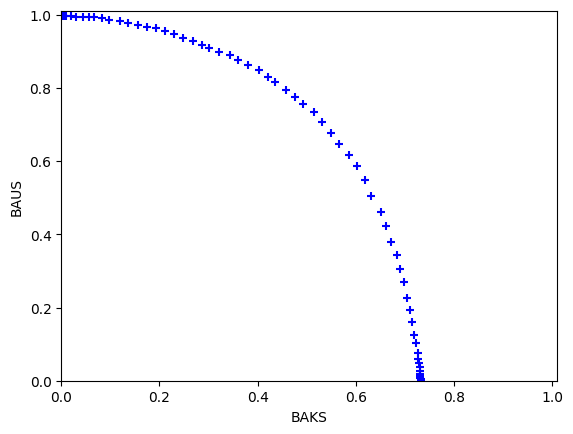

In [9]:
data_baks = np.array([mean(baks[t]) for t in ts])
data_baus = np.array([mean(baus[t]) for t in ts])

plt.scatter(data_baks, data_baus, color='blue', marker='+')
plt.xlabel('BAKS')
plt.ylabel('BAUS')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01]);

Similarity, we plot the normalized accuracy, which is the geometric mean between BAKS and BAUS.

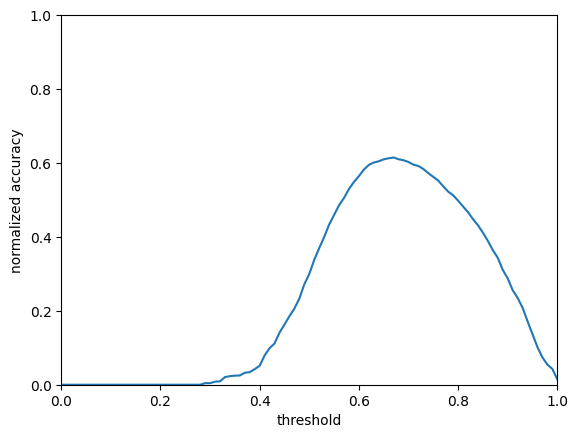

In [10]:
plt.plot(ts, np.sqrt(data_baks * data_baus))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('threshold')
plt.ylabel('normalized accuracy');

Finally, we print the baseline results. For the closed-set, we select the threshold $t=-\infty$, where no predictions are made as new individual. Due to the structure of BAKS, all new individuals from the testing set are ignored during inference. For the open-set, we arbitrarily select the threshold $t=0.7$.

In [11]:
print(f'Closed-set accuracy = {mean(baks[-np.inf])}')
print(f'Open-set normalized accuracy = {np.sqrt(mean(baks[0.7])*mean(baus[0.7]))}')

Closed-set accuracy = 0.73202396719586
Open-set normalized accuracy = 0.6026747791963573
